# Pipeline in Jupyter Notebook

In [1]:
import os
import time

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from transformers import BertTokenizer
import seaborn as sns
import matplotlib.pyplot as plt

from src.data_preprocessing import load_data, preprocess_data, save_processed_data
from src.dataset import ContrastiveTextDataset, SupervisedTextDataset, SupervisedContrastiveTextDataset
from src.contrastive_learning import contrastive_pretrain, supervised_contrastive_pretrain
from src.evaluation import evaluate_classifier
from src.model import BertContrastiveModel
from src.supervised_fine_tune import fine_tune_supervised

/Users/ndminh/Minh/USA/University/University of Houston/Study/MSCS/Spring 2025/COSC 6342/Project/gender-classification/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to venv/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to venv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to venv/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to venv/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Preprocess the data

In [2]:
# Load and preprocess data
raw_data_path = "data/raw/gender-classification.csv"
processed_data_path = "data/processed"
processed_data_filename = "processed_data.csv"
text_column = "text"
label_column = "gender"

In [3]:
# # Load raw data (csv file)
# raw_data = load_data(raw_data_path)

# # Preprocess data
# preprocessed_data = preprocess_data(raw_data, text_column, label_column)

# # Save preprocessed data to a csv file
# save_processed_data(preprocessed_data, processed_data_path, processed_data_filename)

In [4]:
# Load preprocessed data
data_df = load_data(f"{processed_data_path}/{processed_data_filename}")

Data loaded successfully from: data/processed/processed_data.csv


In [5]:
data_df.head()

,text,gender
0,long time see like always rewriting scratch co...,0
1,guest demo eric iversons itty bitty search feb...,0
2,moved cheese world developing areas create dif...,0
3,yesterday attended biweekly meeting informal u...,0
4,liam nothing like natalie natalie never went d...,1


In [6]:
data_df.info()
data_df.describe()
data_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3226 entries, 0 to 3225
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3226 non-null   object
 1   gender  3226 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 50.5+ KB


text      0
gender    0
dtype: int64

### Contrastive Learning
Pre-train the model to learn the representation of the data in order to distinguish between similar and dissimilar data points.

In [7]:
# Texts will be used for contrastive learning
texts = data_df["text"].tolist()
labels = data_df["gender"].tolist()

print("Data loaded and preprocessed.")
print(f"Number of samples: {len(texts)}")
print(f"Number of labels: {len(labels)}")

Data loaded and preprocessed.
Number of samples: 3226
Number of labels: 3226


In [8]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
# Create a custom dataset for contrastive learning
# This will perform data augmentation on the input text samples
# and prepare them for training

# contrastive_dataset = ContrastiveTextDataset(
#     texts, tokenizer, max_length=128, augment=True
# )
contrastive_dataset = SupervisedContrastiveTextDataset(
    texts,
    labels,
    tokenizer,
    max_length=128,
    augment=True,
)

contrastive_loader = DataLoader(contrastive_dataset, batch_size=8, shuffle=True)

print("Contrastive dataset created (with data augmentation).")

Contrastive dataset created (with data augmentation).


In [10]:
# Initialize our model: BERT encoder with projection and classifier heads
model = BertContrastiveModel(proj_dim=64, num_labels=2, dropout_prob=0.3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model initialized and moved to device.")

Model initialized and moved to device.


In [11]:
##################################
# CONTRASTIVE PRE-TRAINING PHASE
##################################


# Initialize the adam optimizer
optimizer_ctr = optim.Adam(model.parameters(), lr=2e-5, weight_decay=1e-4)

# # Run contrastive pre-training
# contrastive_pretrain(
#     model,
#     contrastive_loader,
#     optimizer_ctr,
#     device,
#     num_epochs=5,
#     temperature=0.5,
# )

supervised_contrastive_pretrain(
    model,
    contrastive_loader,
    optimizer_ctr,
    device,
    temperature=0.5,
    num_epochs=5,
)

print("Contrastive pre-training complete. Model saved.")

Supervised Contrastive Pre-training Epoch [1/5] Loss: 2.6947
Supervised Contrastive Pre-training Epoch [2/5] Loss: 2.6807
Supervised Contrastive Pre-training Epoch [3/5] Loss: 2.6541
Supervised Contrastive Pre-training Epoch [4/5] Loss: 2.6039
Supervised Contrastive Pre-training Epoch [5/5] Loss: 2.4912
Model saved at models/bert_supervised_contrastive_pretrained.pth
Supervised Contrastive pre-training complete.
Contrastive pre-training complete. Model saved.


### Supervised Fine-tuning
Fine-tune our pre-trained model on a classification task using labeled data.

In [12]:
# For this phase, we will also need the labels from the dataset

# texts = data_df["text"].tolist()
# labels = data_df["gender"].tolist()

# print("Data loaded and preprocessed.")
# print(f"Number of samples: {len(texts)}")
# print(f"Number of labels: {len(labels)}")

In [13]:
# Create a custom dataset for supervised training
# This will not perform data augmentation on the input text samples
supervised_dataset = SupervisedTextDataset(
    texts, labels, tokenizer, max_length=128, augment=False
)

# Split data: 20% as test; from training, 20% as validation
total_len = len(supervised_dataset)
test_len = int(0.2 * total_len)
remaining = total_len - test_len
val_len = int(0.2 * remaining)
train_len = remaining - val_len

train_dataset, val_dataset, test_dataset = random_split(
    supervised_dataset, [train_len, val_len, test_len]
)

# Create data loaders for training, validation, and testing
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Data loaded and split into train, validation, and test sets.")

Data loaded and split into train, validation, and test sets.


***NOTE: This is important to cool down the machine a bit before running the supervised fine-tuning. After the contrastive learning, the machine will need to "take some rest" before running the next heavy task.***

*Just like a human brain, the machine needs to "rest" before running the next heavy task. It can help in a better performant and more accurate result.*

In [14]:
# Let computer cool down in 5 minutes with no activity
print("Cooling down for 5 minutes...")
time.sleep(300)
print("Cool down complete. Resuming...")

Cooling down for 5 minutes...
Cool down complete. Resuming...


In [15]:
# Initialize our BertContrastiveModel
# model = BertContrastiveModel(proj_dim=64, num_labels=2, dropout_prob=0.3)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# print("Model initialized and moved to device.")

# Load pre-trained contrastive model weights
# pre_trained_path = os.path.join("models", "bert_contrastive_pretrained.pth")
pre_trained_path = os.path.join("models", "bert_supervised_contrastive_pretrained.pth")

# Check if the pre-trained model weights exist
if not os.path.exists(pre_trained_path):
    raise FileNotFoundError(
        f"Pre-trained model weights not found at {pre_trained_path}. Please run supervised contrastive pre-training first."
    )

model.load_state_dict(torch.load(pre_trained_path))

print("Loaded pre-trained supervised contrastive model weights.")

Loaded pre-trained supervised contrastive model weights.


In [16]:
################################
# SUPERVISED FINE-TUNING PHASE
################################


# Initialize the adam optimizer
optimizer_ft = optim.Adam(model.parameters(), lr=2e-5, weight_decay=1e-4)

# Perform model fine-tuning on labeled dataset
history, best_val_acc = fine_tune_supervised(
    model, train_loader, val_loader, optimizer_ft, device, num_epochs=20, patience=3
)

print(f"Best validation accuracy: {best_val_acc:.4f}")
print("Supervised fine-tuning complete. Model saved.")

Epoch [1/20] - Train Loss: 0.2546, Val Loss: 0.1701, Val Acc: 0.9457
Best validation accuracy updated: 0.9457
Best supervised model updated and saved at models/best_bert_supervised.pth
Epoch [2/20] - Train Loss: 0.1108, Val Loss: 0.1445, Val Acc: 0.9574
Best validation accuracy updated: 0.9574
Best supervised model updated and saved at models/best_bert_supervised.pth
Epoch [3/20] - Train Loss: 0.0543, Val Loss: 0.2034, Val Acc: 0.9457
Epoch [4/20] - Train Loss: 0.0342, Val Loss: 0.2440, Val Acc: 0.9380
Epoch [5/20] - Train Loss: 0.0240, Val Loss: 0.2340, Val Acc: 0.9457
Early stopping triggered. No improvement for 3 epochs.
Supervised fine-tuning complete.
Best validation accuracy: 0.9574
Supervised fine-tuning complete. Model saved.


In [17]:
###################################
# Plot supervised learning curves
###################################
def plot_learning_curves(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Train Loss", "Val Loss"], loc="upper right")
    plt.title("Model Training/Validation Loss")

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Learning Curve: Validation Accuracy")

    plt.tight_layout()
    plt.show()

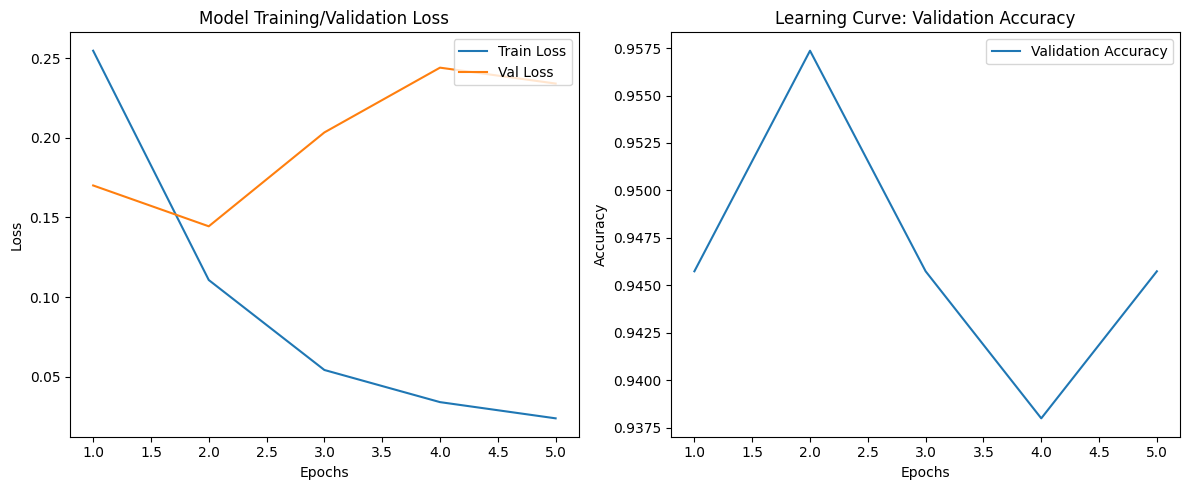

In [18]:
plot_learning_curves(history)

***NOTE: This is important to cool down the machine again a bit before running the evaluation. After the contrastive learning and supervised fine-tuning, the machine is probably very "tired" and will need to "take some rest" before running the evaluation. It can help in a better and more accurate evaluation.***

In [19]:
# Let computer cool down in 5 minutes with no activity
print("Cooling down for 5 minutes...")
time.sleep(300)
print("Cool down complete. Resuming...")

Cooling down for 5 minutes...
Cool down complete. Resuming...


### Evaluation
Evaluate the model on a train/validation/test set to measure its performance.

In [20]:
# Initialize our BertContrastiveModel
model = BertContrastiveModel(proj_dim=64, num_labels=2, dropout_prob=0.3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model initialized and moved to device.")

Model initialized and moved to device.


In [21]:
# Load the supervised model weights
supervised_model_path = os.path.join("models", "best_bert_supervised.pth")
# Check if the supervised model weights exist
if not os.path.exists(supervised_model_path):
    raise FileNotFoundError(
        f"Supervised model weights not found at {supervised_model_path}. Please run supervised fine-tuning first."
    )

model.load_state_dict(torch.load(supervised_model_path))

print("Loaded best supervised model weights.")

Loaded best supervised model weights.


In [22]:
# current_state = model.state_dict()
# print("Current state of the model:")
# for key, value in current_state.items():
#     print(f"{key}: {value.size()}")

In [23]:
def print_eval_results(results):
    """Prints the evaluation results.

    Args:
        results (dict): A dictionary containing evaluation metrics including
            loss, accuracy, f1 score, confusion matrix, and classification report.
    """
    print(f"Loss: {results['loss']:.4f}")
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"F1 Score: {results['f1']:.4f}")
    print("Confusion Matrix:")
    print(results["confusion_matrix"])
    print("Classification Report:")
    print(results["report"])
    print("=" * 30)

Evaluating on train set:
Loss: 0.0437
Accuracy: 0.9918
F1 Score: 0.9918
Classification Report:
              precision    recall  f1-score   support

           M       0.99      1.00      0.99      1079
           F       1.00      0.98      0.99       986

    accuracy                           0.99      2065
   macro avg       0.99      0.99      0.99      2065
weighted avg       0.99      0.99      0.99      2065



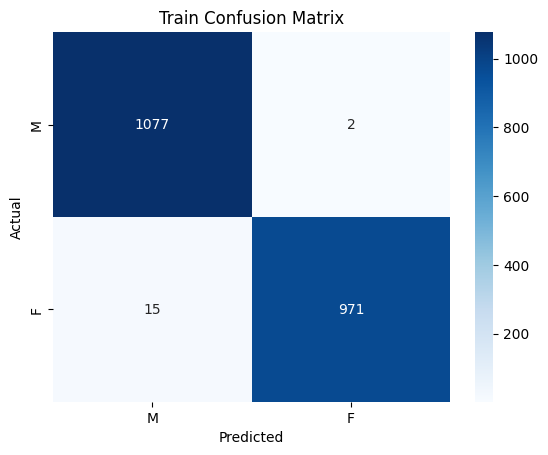

In [24]:
########################################
# Evaluate the model on the all 3 sets
#######################################

print("Evaluating on train set:")
train_eval = evaluate_classifier(model, train_loader, device)
print(f"Loss: {train_eval['loss']:.4f}")
print(f"Accuracy: {train_eval['accuracy']:.4f}")
print(f"F1 Score: {train_eval['f1']:.4f}")
print("Classification Report:")
print(train_eval["report"])

sns.heatmap(
    train_eval["confusion_matrix"],
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["M", "F"],
    yticklabels=["M", "F"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Train Confusion Matrix")
plt.show()

print("=" * 30)

Evaluating on validation set:
Loss: 0.1445
Accuracy: 0.9574
F1 Score: 0.9574
Classification Report:
              precision    recall  f1-score   support

           M       0.95      0.96      0.96       251
           F       0.96      0.95      0.96       265

    accuracy                           0.96       516
   macro avg       0.96      0.96      0.96       516
weighted avg       0.96      0.96      0.96       516



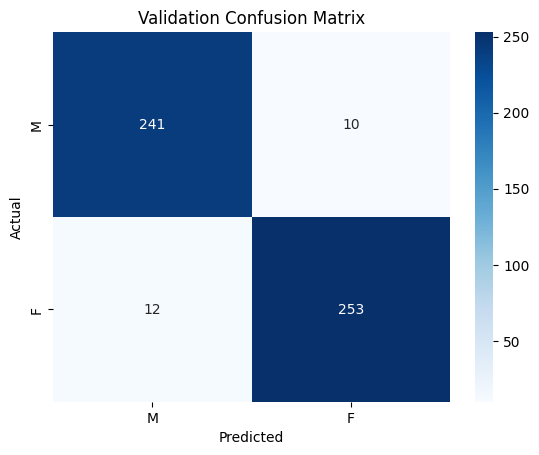

In [25]:
print("Evaluating on validation set:")
val_eval = evaluate_classifier(model, val_loader, device)
print(f"Loss: {val_eval['loss']:.4f}")
print(f"Accuracy: {val_eval['accuracy']:.4f}")
print(f"F1 Score: {val_eval['f1']:.4f}")
print("Classification Report:")
print(val_eval["report"])

sns.heatmap(
    val_eval["confusion_matrix"],
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["M", "F"],
    yticklabels=["M", "F"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Validation Confusion Matrix")
plt.show()

Evaluating on test set:
Loss: 0.1667
Accuracy: 0.9457
F1 Score: 0.9457
Classification Report:
              precision    recall  f1-score   support

           M       0.94      0.96      0.95       348
           F       0.95      0.93      0.94       297

    accuracy                           0.95       645
   macro avg       0.95      0.94      0.95       645
weighted avg       0.95      0.95      0.95       645



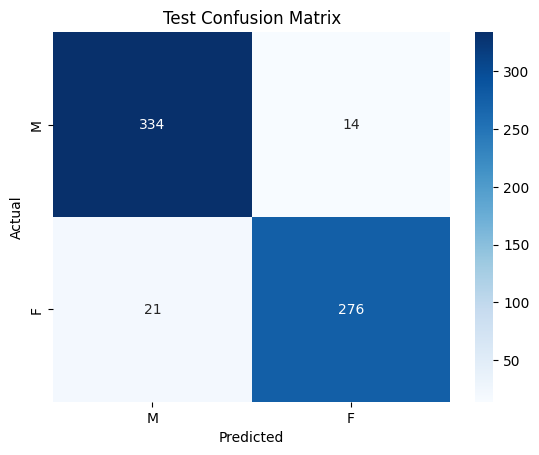

Evaluation complete.


In [26]:
print("Evaluating on test set:")
test_eval = evaluate_classifier(model, test_loader, device)
print(f"Loss: {test_eval['loss']:.4f}")
print(f"Accuracy: {test_eval['accuracy']:.4f}")
print(f"F1 Score: {test_eval['f1']:.4f}")
print("Classification Report:")
print(test_eval["report"])

sns.heatmap(
    test_eval["confusion_matrix"],
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["M", "F"],
    yticklabels=["M", "F"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Confusion Matrix")
plt.show()

print("=" * 30)
print("Evaluation complete.")